Mounting Google Drive

In [1]:
!pip install torchsummary

In [2]:
!pip install --quiet torch_lr_finder


In [3]:
!git clone https://github.com/sushant097/era_support_packages.git

Cloning into 'era_support_packages'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 4), reused 16 (delta 4), pack-reused 0
Receiving objects: 100% (16/16), done.
Resolving deltas: 100% (4/4), done.


Importing libraries

In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

from era_support_packages.utils import (
   test, train, plot_losses, plot_incorrect_prediction

)

from era_support_packages.custom_resnet import resnet_custom
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Updating Device to CUDA

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Defining data tranformations

In [6]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout (max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=.45, mask_fill_value = None),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=15, p=0.4),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
test_transforms = A.Compose(
    [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ]
)

Custom Dataset that support albumentation library

In [7]:
class Cifar10DS(datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


Downloading MNIST dataset and splitting to train and test set

In [8]:
train_data = Cifar10DS('../data', train=True, download=True, transform=train_transforms)
test_data = Cifar10DS('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:14<00:00, 11943155.72it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [9]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Creating Data Loaders from train data and test data

In [10]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

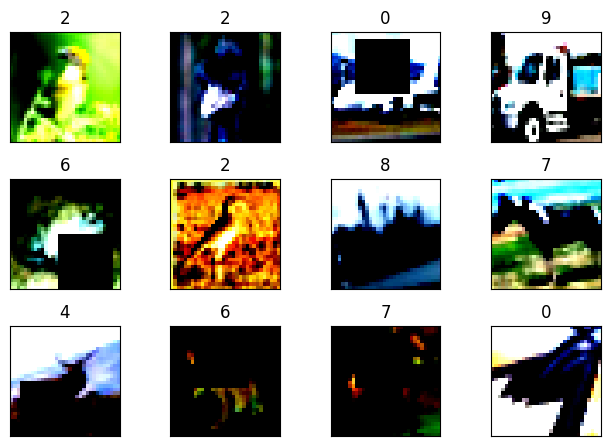

In [11]:
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i], (1, 2, 0)), cmap='gray')
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])
plt.show()

Transferring model to GPU and printing model summary

In [12]:
model = resnet_custom(norm="BN", groupsize=1).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-04


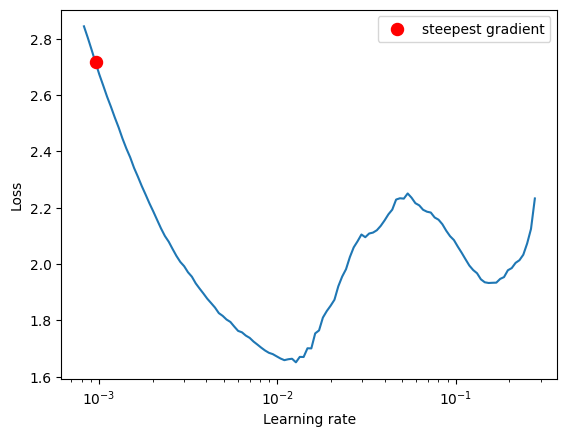

In [13]:
from torch_lr_finder import LRFinder
import torch.nn as nn

model = resnet_custom(norm="BN", groupsize=1).to(device)
optimizer_lr = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer_lr, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [14]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.01270074066032273


In [15]:
optimizer = optim.SGD(model.parameters(), lr=8.22E-04, weight_decay=1e-4)
EPOCHS = 25

In [16]:
scheduler = OneCycleLR(
        optimizer,
        max_lr= ler_rate,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=10,
        anneal_strategy='linear'
    )

In [17]:

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, criterion, epoch)
    test(model, device, test_loader, criterion)

EPOCH: 0


Train: Loss=1.3483 Batch_id=97 Accuracy=36.94: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]


Test set: Average loss: 0.0026, Accuracy: 5412/10000 (54.12%)

EPOCH: 1


Train: Loss=1.1810 Batch_id=97 Accuracy=51.17: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Test set: Average loss: 0.0021, Accuracy: 6186/10000 (61.86%)

EPOCH: 2


Train: Loss=1.1974 Batch_id=97 Accuracy=57.76: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.0019, Accuracy: 6718/10000 (67.18%)

EPOCH: 3


Train: Loss=1.0488 Batch_id=97 Accuracy=61.91: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


Test set: Average loss: 0.0017, Accuracy: 6971/10000 (69.71%)

EPOCH: 4


Train: Loss=1.0586 Batch_id=97 Accuracy=65.56: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]


Test set: Average loss: 0.0015, Accuracy: 7297/10000 (72.97%)

EPOCH: 5


Train: Loss=0.8744 Batch_id=97 Accuracy=68.12: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7495/10000 (74.95%)

EPOCH: 6


Train: Loss=0.8129 Batch_id=97 Accuracy=70.81: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]


Test set: Average loss: 0.0013, Accuracy: 7707/10000 (77.07%)

EPOCH: 7


Train: Loss=0.9239 Batch_id=97 Accuracy=72.43: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.0013, Accuracy: 7723/10000 (77.23%)

EPOCH: 8


Train: Loss=0.7687 Batch_id=97 Accuracy=73.96: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]


Test set: Average loss: 0.0012, Accuracy: 7879/10000 (78.79%)

EPOCH: 9


Train: Loss=0.7634 Batch_id=97 Accuracy=75.37: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


Test set: Average loss: 0.0012, Accuracy: 8043/10000 (80.43%)

EPOCH: 10


Train: Loss=0.6990 Batch_id=97 Accuracy=76.56: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]


Test set: Average loss: 0.0012, Accuracy: 8015/10000 (80.15%)

EPOCH: 11


Train: Loss=0.5854 Batch_id=97 Accuracy=78.06: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


Test set: Average loss: 0.0011, Accuracy: 8101/10000 (81.01%)

EPOCH: 12


Train: Loss=0.5614 Batch_id=97 Accuracy=78.97: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Test set: Average loss: 0.0011, Accuracy: 8163/10000 (81.63%)

EPOCH: 13


Train: Loss=0.5299 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


Test set: Average loss: 0.0011, Accuracy: 8207/10000 (82.07%)

EPOCH: 14


Train: Loss=0.5633 Batch_id=97 Accuracy=80.48: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Test set: Average loss: 0.0010, Accuracy: 8258/10000 (82.58%)

EPOCH: 15


Train: Loss=0.5953 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]


Test set: Average loss: 0.0011, Accuracy: 8199/10000 (81.99%)

EPOCH: 16


Train: Loss=0.5516 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Test set: Average loss: 0.0010, Accuracy: 8324/10000 (83.24%)

EPOCH: 17


Train: Loss=0.4758 Batch_id=97 Accuracy=82.80: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


Test set: Average loss: 0.0010, Accuracy: 8277/10000 (82.77%)

EPOCH: 18


Train: Loss=0.5377 Batch_id=97 Accuracy=83.06: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Test set: Average loss: 0.0011, Accuracy: 8236/10000 (82.36%)

EPOCH: 19


Train: Loss=0.5058 Batch_id=97 Accuracy=84.12: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


Test set: Average loss: 0.0010, Accuracy: 8435/10000 (84.35%)

EPOCH: 20


Train: Loss=0.4408 Batch_id=97 Accuracy=84.73: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Test set: Average loss: 0.0010, Accuracy: 8409/10000 (84.09%)

EPOCH: 21


Train: Loss=0.3460 Batch_id=97 Accuracy=84.95: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


Test set: Average loss: 0.0009, Accuracy: 8448/10000 (84.48%)

EPOCH: 22


Train: Loss=0.3622 Batch_id=97 Accuracy=85.27: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Test set: Average loss: 0.0009, Accuracy: 8491/10000 (84.91%)

EPOCH: 23


Train: Loss=0.4281 Batch_id=97 Accuracy=86.35: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Test set: Average loss: 0.0009, Accuracy: 8465/10000 (84.65%)

EPOCH: 24


Train: Loss=0.3962 Batch_id=97 Accuracy=86.28: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]


Test set: Average loss: 0.0009, Accuracy: 8494/10000 (84.94%)



## Plot Losses

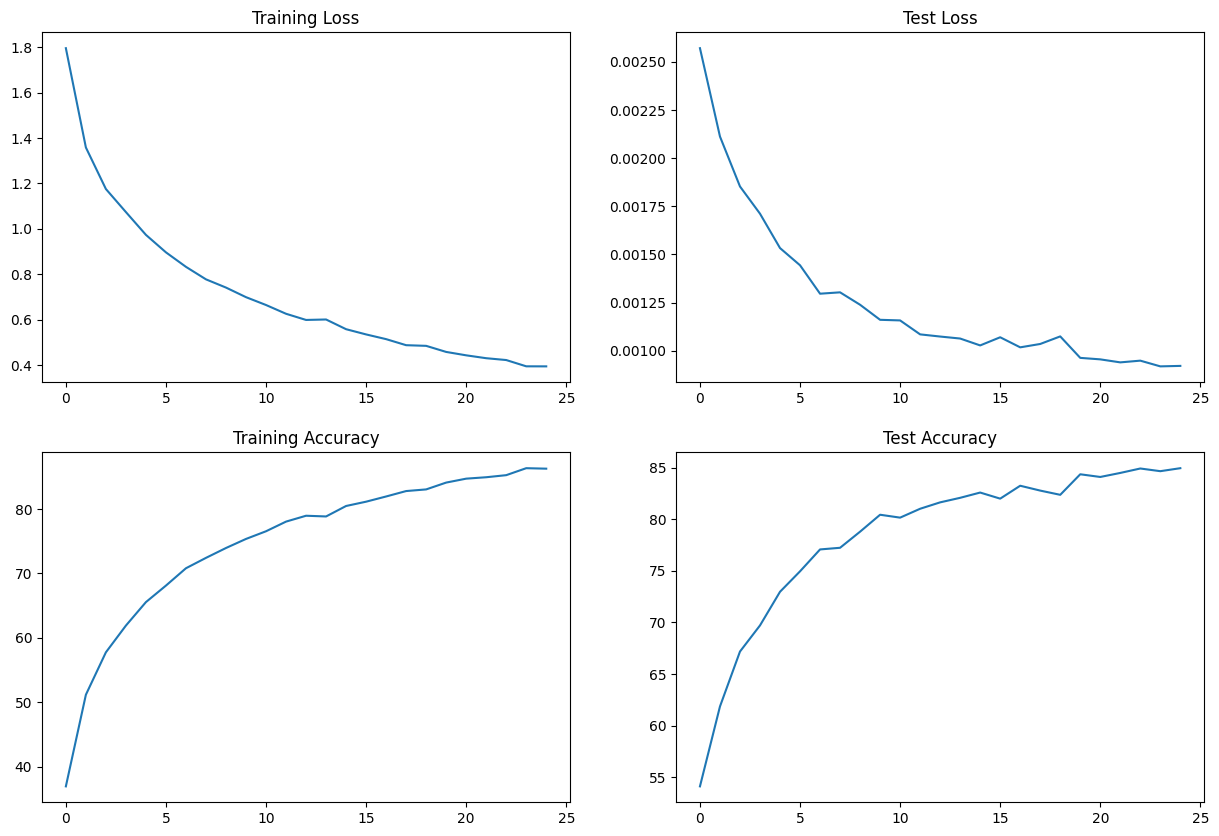

In [18]:
plot_losses()

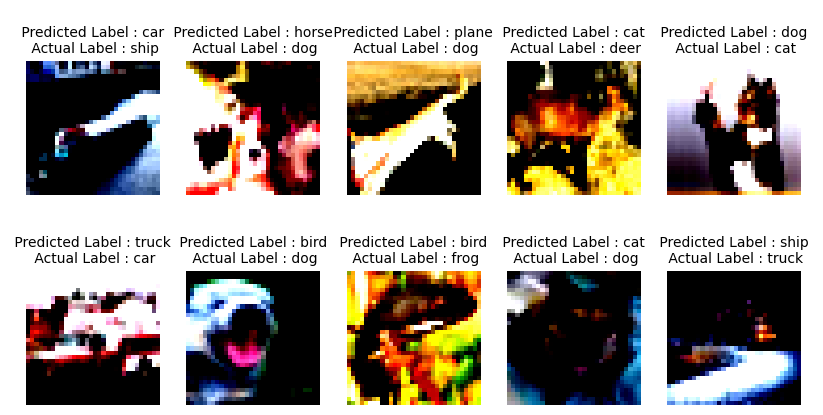

In [19]:
wrong_prediction_list = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the maximum probabilities
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
plot_incorrect_prediction(wrong_prediction_list, n=10 )